# CIFAR-10 DCGAN Implementation

This notebook implements a Deep Convolutional Generative Adversarial Network (DCGAN) trained on the CIFAR-10 dataset using PyTorch. This follows a similar structure to the MNIST GAN implementation but adapts the architecture for the more complex CIFAR-10 dataset with color images.

## Notebook Overview
1. **Setup and Imports**: Libraries and device configuration
2. **Hyperparameters**: Configuration for the DCGAN training
3. **Model Architecture**: Implementation of DCGAN Generator and Discriminator networks
4. **Data Loading**: CIFAR-10 dataset preparation with options for subset selection
5. **Visualization Functions**: Utilities for tracking GAN performance
6. **Training Loop**: Implementation of the DCGAN training process
7. **Execution and Results**: Running the training and analyzing outputs

## 1. Setup and Imports

First, we'll import the necessary libraries and set up the computational device (CPU or GPU).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os
import time
import random
from PIL import Image

# Set random seed for reproducibility
seed = 64

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(seed)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Hyperparameters

Here we define all the hyperparameters that control the DCGAN training process:

In [2]:
# Hyperparameters
batch_size = 128
latent_dim = 100       # Size of generator input noise vector
image_channels = 3     # RGB images
ngf = 64               # Size of feature maps in generator
ndf = 64               # Size of feature maps in discriminator
lr = 0.0002            # Learning rate
beta1 = 0.5            # Adam optimizer beta1
beta2 = 0.999          # Adam optimizer beta2
num_epochs = 50       # Number of training epochs
sample_interval = 10   # Save images every 10 epochs

## 3. Model Architecture

### Generator Network

For CIFAR-10, we'll use a proper DCGAN architecture with transposed convolutions (also called deconvolutions). This is more suitable for generating higher resolution color images compared to the simple MLP used in the MNIST example.

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, ngf, image_channels):
        super(Generator, self).__init__()
        
        # Starting from latent_dim random noise, project and reshape
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size: ngf x 32 x 32
            nn.ConvTranspose2d(ngf, image_channels, 3, 1, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )

    def forward(self, z):
        # Reshape the input from (batch_size, latent_dim) to (batch_size, latent_dim, 1, 1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.main(z)

### Discriminator Network

The discriminator uses convolutional layers to classify the input images as real or fake.

In [4]:
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self, ndf, image_channels):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # Input: 3 x 32 x 32
            spectral_norm(nn.Conv2d(image_channels, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: ndf x 16 x 16
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (ndf*2) x 8 x 8
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (ndf*4) x 4 x 4
            spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

### Initialize Models and Optimizers

Here we:
1. Initialize both networks
2. Define the loss function (Binary Cross Entropy)
3. Set up optimizers for both networks

In [5]:
import torch.nn as nn
set_random_seed(seed)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
set_random_seed(seed)
# Initialize models
generator = Generator(latent_dim, ngf, image_channels).to(device)
discriminator = Discriminator(ndf, image_channels).to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

## 4. Data Loading

Here we set up the CIFAR-10 dataset with appropriate transformations and support for subset selection.

In [7]:
def load_data(subset_percentage=100):
    """
    Load CIFAR-10 dataset
    
    Parameters:
    - subset_percentage: Percentage of the full dataset to use (integer from 1-100)
    
    Returns:
    - DataLoader and Dataset objects
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])
    
    full_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    all_targets = np.array(full_dataset.targets)
    
    # Count instances of each class
    class_counts = [0] * 10
    for label in all_targets:
        class_counts[label] += 1
    
    print(f"Full CIFAR-10 dataset distribution:")
    for class_idx, count in enumerate(class_counts):
        print(f"{class_names[class_idx]}: {count} samples")
    
    if subset_percentage == 100:
        selected_dataset = full_dataset
    else:
        # Stratified sampling to maintain class distribution
        class_indices = [[] for _ in range(10)]
        
        for idx, label in enumerate(all_targets):
            class_indices[label].append(idx)
        
        total_subset_size = int(len(full_dataset) * subset_percentage / 100)
        samples_per_class = total_subset_size // 10
        
        stratified_indices = []
        for class_idx in range(10):
            class_idx_list = class_indices[class_idx]
            random_idx = torch.randperm(len(class_idx_list))
            selected_idx = [class_idx_list[i] for i in random_idx[:samples_per_class]]
            stratified_indices.extend(selected_idx)
            
        random.shuffle(stratified_indices)
        selected_dataset = Subset(full_dataset, stratified_indices)
        
        # Count the class distribution in the subset
        subset_targets = [all_targets[i] for i in stratified_indices]
        subset_class_counts = [0] * 10
        for label in subset_targets:
            subset_class_counts[label] += 1
        
        print(f"\nStratified subset distribution:")
        for class_idx, count in enumerate(subset_class_counts):
            print(f"{class_names[class_idx]}: {count} samples")
    
    data_loader = DataLoader(
        selected_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True  # Discard incomplete batches
    )
    
    print(f"\nFull dataset size: {len(full_dataset)} images")
    print(f"Selected subset size: {len(selected_dataset)} images")
    print(f"Number of batches: {len(data_loader)}")
    
    return data_loader, selected_dataset

## 5. Visualization Functions

These utility functions help monitor the GAN's progress.

In [8]:
def save_generated_images(epoch, generator, latent_dim, device, subset_percentage,
                         fixed_noise=None, base_path="./generated_images"):
    
    subfolder = f"cifar10_subset_{subset_percentage}_percent"
    save_path = os.path.join(base_path, subfolder)
    os.makedirs(save_path, exist_ok=True)
    
    # Create a batch of latent vectors or use fixed noise for comparison
    if fixed_noise is None:
        z = torch.randn(25, latent_dim).to(device)
    else:
        z = fixed_noise
    
    # Generate images
    with torch.no_grad():
        gen_imgs = generator(z).detach().cpu()
    
    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    grid = make_grid(gen_imgs, nrow=5, normalize=True)
    
    filename = f"epoch_{epoch:03d}.png"
    filepath = os.path.join(save_path, filename)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Generated CIFAR-10 Images - {subset_percentage}% Data - Epoch {epoch}")

    plt.savefig(filepath, dpi=300)
    plt.show()
    
    return grid

In [9]:
def plot_losses(g_losses, d_losses, subset_percentage, save_path="./loss_plots"):
    # Create folder structure
    os.makedirs(save_path, exist_ok=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title(f'CIFAR-10 DCGAN Training Losses - {subset_percentage}% Data')
    
    plt.savefig(f"{save_path}/cifar10_losses_subset_{subset_percentage}_percent.png")
    plt.show()

In [10]:
def visualize_dataset_samples(dataset, n_samples=25):
    """Display random samples from the dataset"""
    # Get a random sample of images
    indices = torch.randperm(len(dataset))[:n_samples]
    
    sample_images = []
    for idx in indices:
        if isinstance(dataset, Subset):
            img, _ = dataset.dataset[dataset.indices[idx]]  # For subset datasets
        else:
            img, _ = dataset[idx]  # For regular datasets
        sample_images.append(img)
    
    # Convert to grid
    img_grid = make_grid(sample_images, nrow=5, normalize=True)
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("CIFAR-10 Dataset Samples")
    plt.show()

## 6. Training Loop

The DCGAN training function implements the adversarial training process.

In [11]:
def train_gan(subset_percentage=100):
    # Generate fixed noise for consistent image generation
    fixed_noise = torch.randn(64, latent_dim, device=device)
    
    # Load the selected dataset
    train_loader, train_dataset = load_data(subset_percentage)
    
    # Lists to store losses
    g_losses = []
    d_losses = []
    start_time = time.time()
    
    print(f"Starting Training on CIFAR-10 Dataset...")
    for epoch in range(num_epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        batch_count = 0
        
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_count += 1
            
            # Configure input
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Create labels with a small amount of label smoothing
            valid = torch.ones(batch_size, 1).to(device) * 0.9
            fake = torch.zeros(batch_size, 1).to(device)
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            # Loss on real images
            real_pred = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_pred, valid)
            
            # Sample noise and generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Loss on fake images
            fake_pred = discriminator(fake_imgs.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake)
            
            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()
            
            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()
            
            # Generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Try to fool the discriminator
            validity = discriminator(fake_imgs)
            
            # Non-saturating loss for better gradient flow
            g_loss = -torch.mean(torch.log(validity + 1e-8)) 
            
            g_loss.backward()
            optimizer_G.step()
            
            # Save losses for plotting
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
            
            # Print progress
            if i % 100 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                      f"[Time: {time.time() - start_time:.2f}s]")
        
        # Calculate and store average losses for this epoch
        g_losses.append(g_loss_epoch / batch_count)
        d_losses.append(d_loss_epoch / batch_count)
        
        # Print epoch summary
        print(f"[Epoch {epoch}/{num_epochs}] "
              f"[Avg D loss: {d_losses[-1]:.4f}] [Avg G loss: {g_losses[-1]:.4f}]")

        # Save generated images at specified intervals
        if epoch % sample_interval == 0 or epoch == num_epochs - 1:
            _ = save_generated_images(epoch, generator, latent_dim, device, 
                                     subset_percentage, fixed_noise)
            
        # Plot losses at intervals
        if epoch % 10 == 0:
            plot_losses(g_losses, d_losses, subset_percentage)
    
    # Final loss plot
    plot_losses(g_losses, d_losses, subset_percentage)
    
    print("Training finished!")
    print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")
    
    # Save models
    model_path = f"./models/cifar10_subset_{subset_percentage}_percent"
    os.makedirs(model_path, exist_ok=True)
    torch.save(generator.state_dict(), f'{model_path}/generator.pth')
    torch.save(discriminator.state_dict(), f'{model_path}/discriminator.pth')
    
    print("Models saved!")
    
    return g_losses, d_losses

## 7. Execution and Results

Now we'll run the training function and analyze the results.

In [12]:
def generate_samples():
    """Generate and display random samples from the trained generator"""
    with torch.no_grad():
        # Generate random noise
        z = torch.randn(16, latent_dim).to(device)
        # Generate images
        samples = generator(z).detach().cpu()
        # Rescale images
        samples = 0.5 * samples + 0.5
        # Display images
        grid = make_grid(samples, nrow=4, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title("Random CIFAR-10 Samples from Trained Generator")
        plt.show()

Files already downloaded and verified
Full CIFAR-10 dataset distribution:
airplane: 5000 samples
automobile: 5000 samples
bird: 5000 samples
cat: 5000 samples
deer: 5000 samples
dog: 5000 samples
frog: 5000 samples
horse: 5000 samples
ship: 5000 samples
truck: 5000 samples

Stratified subset distribution:
airplane: 4500 samples
automobile: 4500 samples
bird: 4500 samples
cat: 4500 samples
deer: 4500 samples
dog: 4500 samples
frog: 4500 samples
horse: 4500 samples
ship: 4500 samples
truck: 4500 samples

Full dataset size: 50000 images
Selected subset size: 45000 images
Number of batches: 351
Starting Training on CIFAR-10 Dataset...
[Epoch 0/50] [Batch 0/351] [D loss: 1.6326] [G loss: 2.2725] [Time: 0.95s]
[Epoch 0/50] [Batch 100/351] [D loss: 1.0214] [G loss: 2.7600] [Time: 7.24s]
[Epoch 0/50] [Batch 200/351] [D loss: 0.7052] [G loss: 3.8835] [Time: 13.57s]
[Epoch 0/50] [Batch 300/351] [D loss: 0.8034] [G loss: 3.0920] [Time: 19.74s]
[Epoch 0/50] [Avg D loss: 0.8104] [Avg G loss: 3.5694

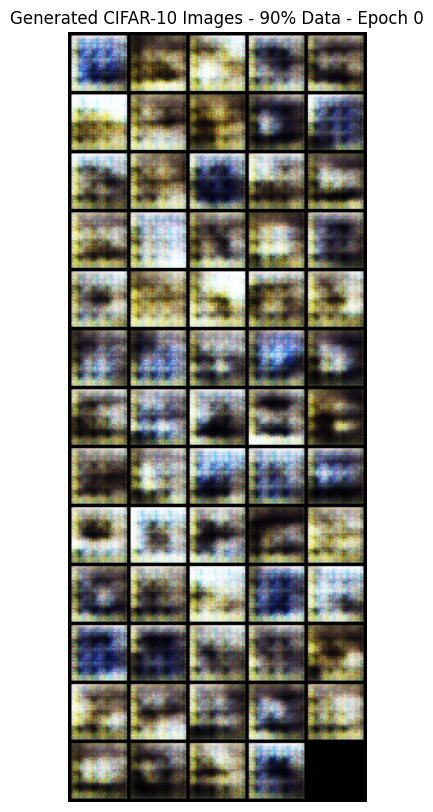

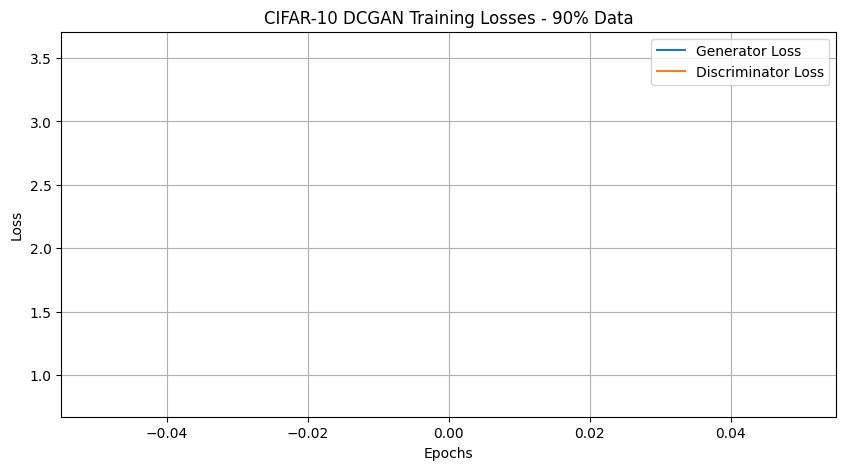

[Epoch 1/50] [Batch 0/351] [D loss: 0.7405] [G loss: 2.7183] [Time: 23.86s]
[Epoch 1/50] [Batch 100/351] [D loss: 1.0211] [G loss: 3.2285] [Time: 30.17s]
[Epoch 1/50] [Batch 200/351] [D loss: 0.5891] [G loss: 3.0466] [Time: 36.38s]
[Epoch 1/50] [Batch 300/351] [D loss: 0.9418] [G loss: 2.5507] [Time: 42.48s]
[Epoch 1/50] [Avg D loss: 0.8058] [Avg G loss: 2.8762]
[Epoch 2/50] [Batch 0/351] [D loss: 0.6878] [G loss: 2.7565] [Time: 45.65s]
[Epoch 2/50] [Batch 100/351] [D loss: 0.7054] [G loss: 2.3614] [Time: 51.87s]
[Epoch 2/50] [Batch 200/351] [D loss: 0.6961] [G loss: 2.6782] [Time: 57.85s]
[Epoch 2/50] [Batch 300/351] [D loss: 1.0701] [G loss: 2.0379] [Time: 63.81s]
[Epoch 2/50] [Avg D loss: 0.7859] [Avg G loss: 2.8776]
[Epoch 3/50] [Batch 0/351] [D loss: 0.7783] [G loss: 2.2393] [Time: 66.90s]
[Epoch 3/50] [Batch 100/351] [D loss: 0.8774] [G loss: 2.3110] [Time: 73.00s]
[Epoch 3/50] [Batch 200/351] [D loss: 0.8828] [G loss: 2.5356] [Time: 79.17s]
[Epoch 3/50] [Batch 300/351] [D loss: 

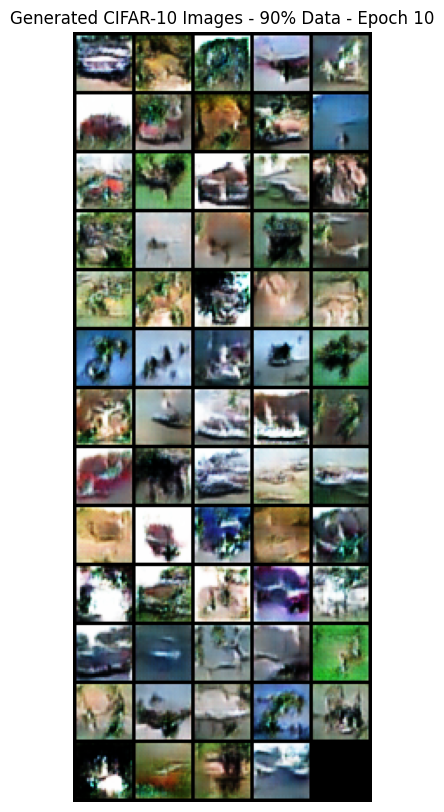

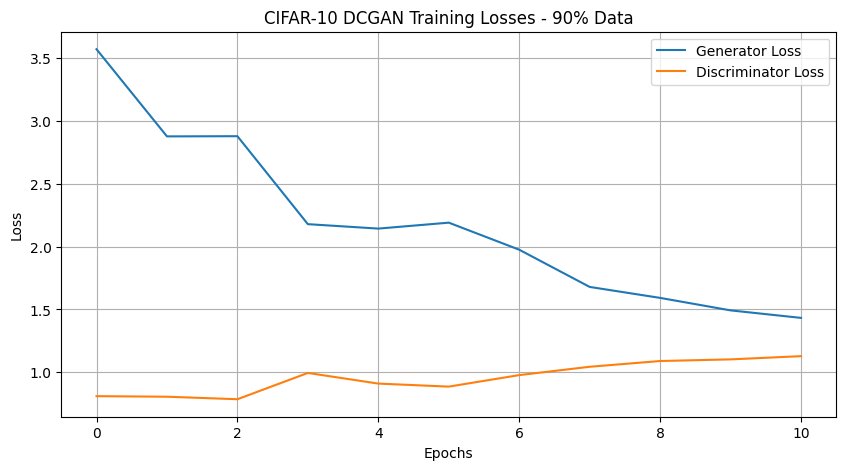

[Epoch 11/50] [Batch 0/351] [D loss: 1.2615] [G loss: 1.5507] [Time: 240.27s]
[Epoch 11/50] [Batch 100/351] [D loss: 1.1427] [G loss: 1.4144] [Time: 246.42s]
[Epoch 11/50] [Batch 200/351] [D loss: 1.1117] [G loss: 1.3609] [Time: 252.58s]
[Epoch 11/50] [Batch 300/351] [D loss: 1.0851] [G loss: 1.2268] [Time: 259.58s]
[Epoch 11/50] [Avg D loss: 1.1279] [Avg G loss: 1.3650]
[Epoch 12/50] [Batch 0/351] [D loss: 1.1162] [G loss: 1.2388] [Time: 263.09s]
[Epoch 12/50] [Batch 100/351] [D loss: 1.1509] [G loss: 1.2983] [Time: 269.54s]
[Epoch 12/50] [Batch 200/351] [D loss: 1.0746] [G loss: 1.4883] [Time: 276.03s]
[Epoch 12/50] [Batch 300/351] [D loss: 1.0965] [G loss: 1.0770] [Time: 282.10s]
[Epoch 12/50] [Avg D loss: 1.1476] [Avg G loss: 1.3314]
[Epoch 13/50] [Batch 0/351] [D loss: 1.1627] [G loss: 1.5032] [Time: 285.25s]
[Epoch 13/50] [Batch 100/351] [D loss: 1.1733] [G loss: 1.4499] [Time: 291.87s]
[Epoch 13/50] [Batch 200/351] [D loss: 1.0165] [G loss: 1.2368] [Time: 298.13s]
[Epoch 13/50] 

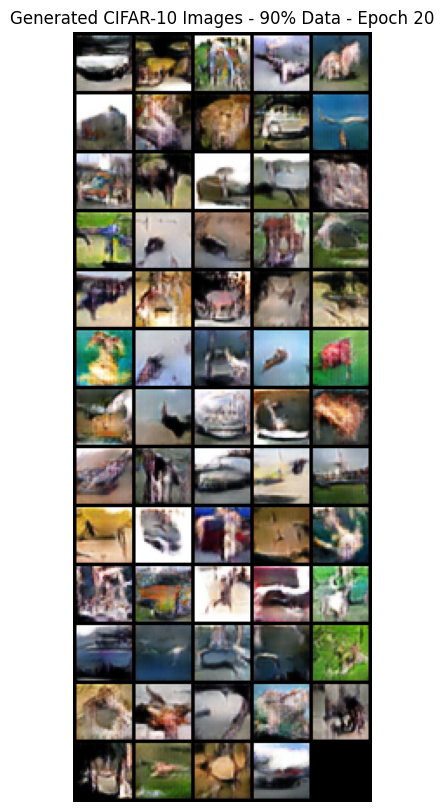

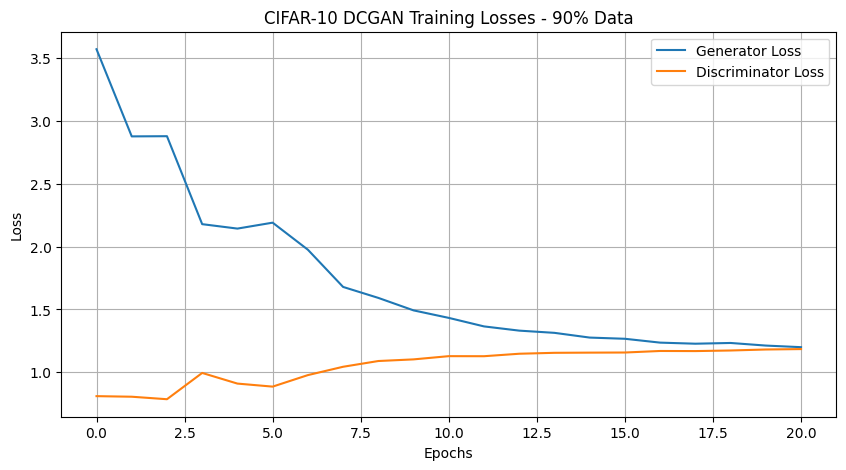

[Epoch 21/50] [Batch 0/351] [D loss: 1.2296] [G loss: 1.4053] [Time: 459.10s]
[Epoch 21/50] [Batch 100/351] [D loss: 1.1814] [G loss: 1.1567] [Time: 465.18s]
[Epoch 21/50] [Batch 200/351] [D loss: 1.1726] [G loss: 1.1020] [Time: 471.24s]
[Epoch 21/50] [Batch 300/351] [D loss: 1.1364] [G loss: 1.4787] [Time: 477.27s]
[Epoch 21/50] [Avg D loss: 1.1840] [Avg G loss: 1.1737]
[Epoch 22/50] [Batch 0/351] [D loss: 1.2915] [G loss: 0.9723] [Time: 480.42s]
[Epoch 22/50] [Batch 100/351] [D loss: 1.2233] [G loss: 1.1744] [Time: 486.59s]
[Epoch 22/50] [Batch 200/351] [D loss: 1.2669] [G loss: 1.2680] [Time: 492.63s]
[Epoch 22/50] [Batch 300/351] [D loss: 1.2683] [G loss: 1.0398] [Time: 498.68s]
[Epoch 22/50] [Avg D loss: 1.1959] [Avg G loss: 1.1708]
[Epoch 23/50] [Batch 0/351] [D loss: 1.2809] [G loss: 1.2712] [Time: 501.80s]
[Epoch 23/50] [Batch 100/351] [D loss: 1.1485] [G loss: 1.8206] [Time: 507.84s]
[Epoch 23/50] [Batch 200/351] [D loss: 1.2490] [G loss: 1.0215] [Time: 513.91s]
[Epoch 23/50] 

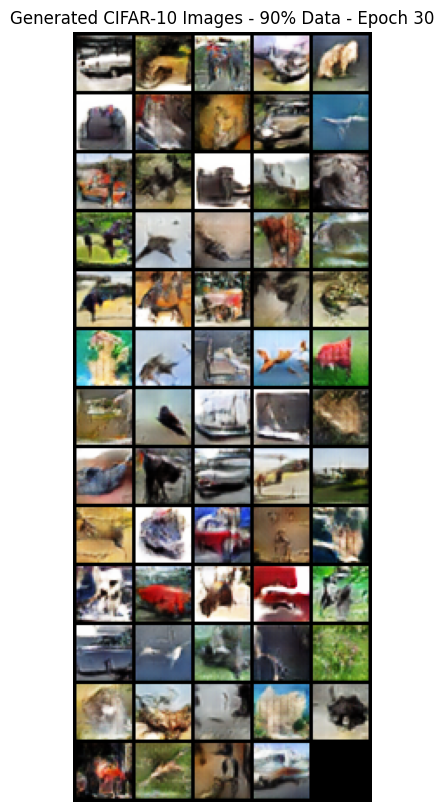

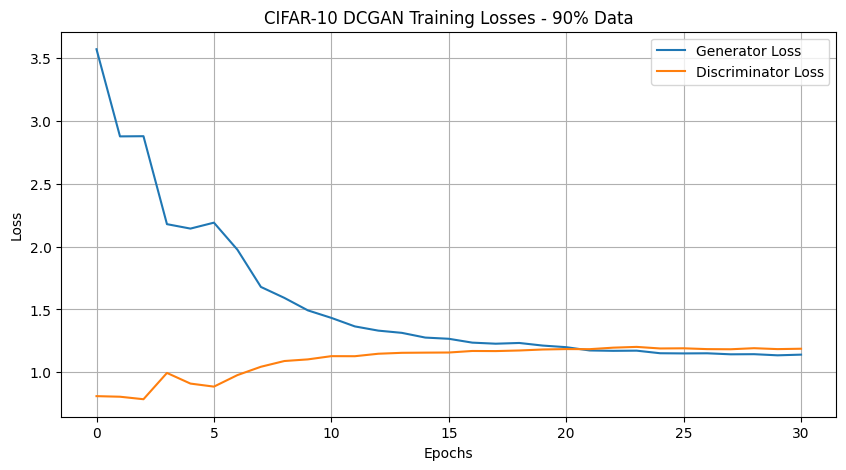

[Epoch 31/50] [Batch 0/351] [D loss: 1.3156] [G loss: 0.9968] [Time: 674.89s]
[Epoch 31/50] [Batch 100/351] [D loss: 1.1542] [G loss: 1.0765] [Time: 681.23s]
[Epoch 31/50] [Batch 200/351] [D loss: 1.1380] [G loss: 1.1141] [Time: 687.67s]
[Epoch 31/50] [Batch 300/351] [D loss: 1.2111] [G loss: 0.9866] [Time: 693.70s]
[Epoch 31/50] [Avg D loss: 1.1829] [Avg G loss: 1.1298]
[Epoch 32/50] [Batch 0/351] [D loss: 1.1793] [G loss: 1.0584] [Time: 696.72s]
[Epoch 32/50] [Batch 100/351] [D loss: 1.2041] [G loss: 1.3234] [Time: 702.72s]
[Epoch 32/50] [Batch 200/351] [D loss: 1.2193] [G loss: 0.9863] [Time: 708.70s]
[Epoch 32/50] [Batch 300/351] [D loss: 1.2054] [G loss: 1.0165] [Time: 714.81s]
[Epoch 32/50] [Avg D loss: 1.1855] [Avg G loss: 1.1267]
[Epoch 33/50] [Batch 0/351] [D loss: 1.2232] [G loss: 1.1239] [Time: 717.81s]
[Epoch 33/50] [Batch 100/351] [D loss: 1.1993] [G loss: 1.1692] [Time: 723.97s]
[Epoch 33/50] [Batch 200/351] [D loss: 1.1409] [G loss: 1.1002] [Time: 729.95s]
[Epoch 33/50] 

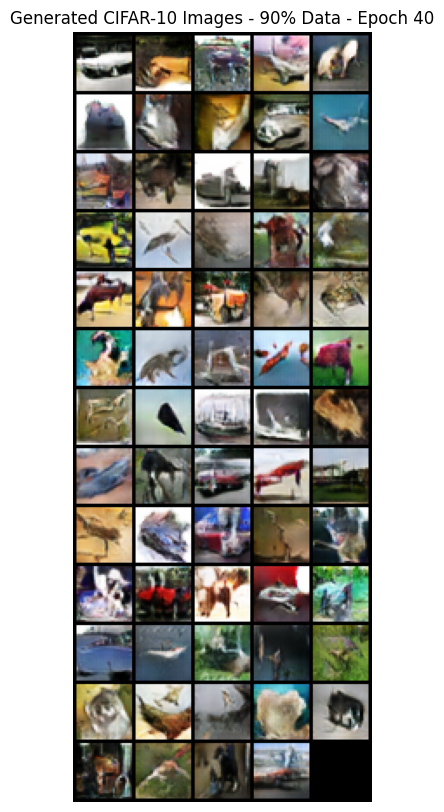

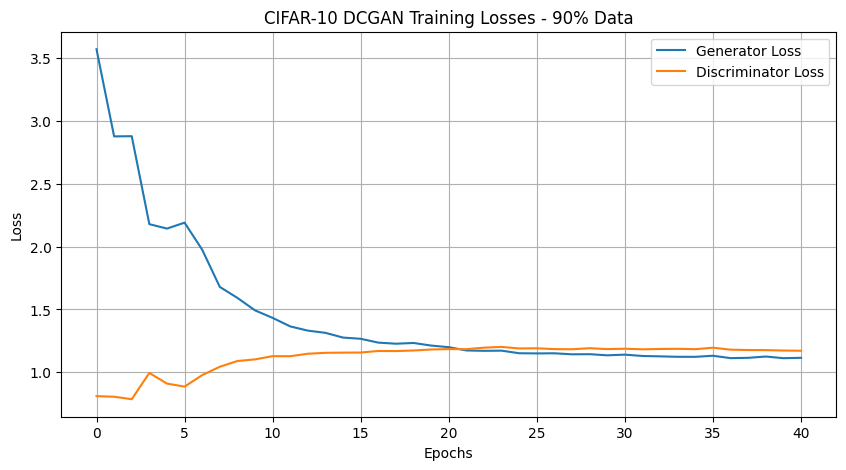

[Epoch 41/50] [Batch 0/351] [D loss: 1.1178] [G loss: 1.0037] [Time: 889.92s]
[Epoch 41/50] [Batch 100/351] [D loss: 1.1764] [G loss: 1.1630] [Time: 896.14s]
[Epoch 41/50] [Batch 200/351] [D loss: 1.1534] [G loss: 1.2584] [Time: 902.34s]
[Epoch 41/50] [Batch 300/351] [D loss: 1.2711] [G loss: 0.9998] [Time: 908.26s]
[Epoch 41/50] [Avg D loss: 1.1697] [Avg G loss: 1.1208]
[Epoch 42/50] [Batch 0/351] [D loss: 1.1303] [G loss: 1.3729] [Time: 911.28s]
[Epoch 42/50] [Batch 100/351] [D loss: 1.1110] [G loss: 1.1491] [Time: 917.33s]
[Epoch 42/50] [Batch 200/351] [D loss: 1.1708] [G loss: 1.0062] [Time: 923.34s]
[Epoch 42/50] [Batch 300/351] [D loss: 1.1815] [G loss: 1.0574] [Time: 929.38s]
[Epoch 42/50] [Avg D loss: 1.1664] [Avg G loss: 1.1186]
[Epoch 43/50] [Batch 0/351] [D loss: 1.0186] [G loss: 1.3229] [Time: 932.55s]
[Epoch 43/50] [Batch 100/351] [D loss: 1.1461] [G loss: 0.8624] [Time: 938.61s]
[Epoch 43/50] [Batch 200/351] [D loss: 1.1537] [G loss: 1.2065] [Time: 944.56s]
[Epoch 43/50] 

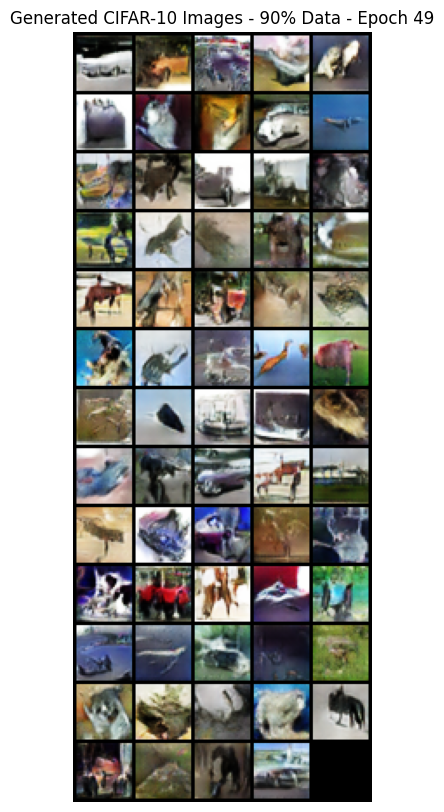

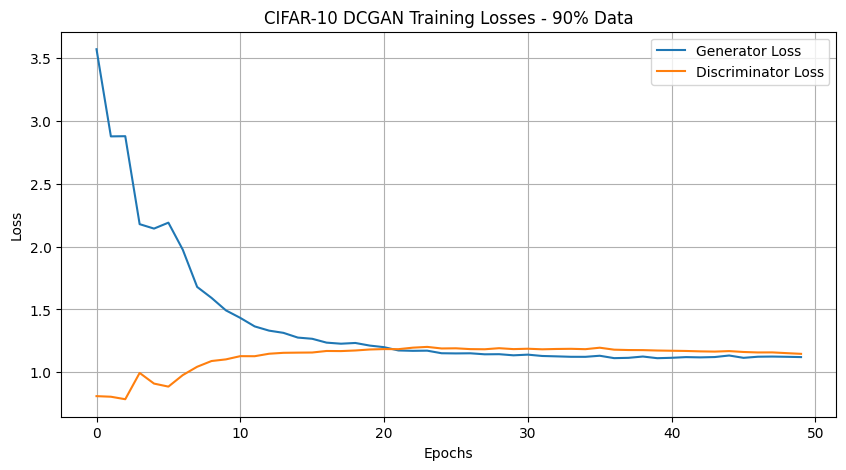

Training finished!
Total training time: 17.97 minutes
Models saved!


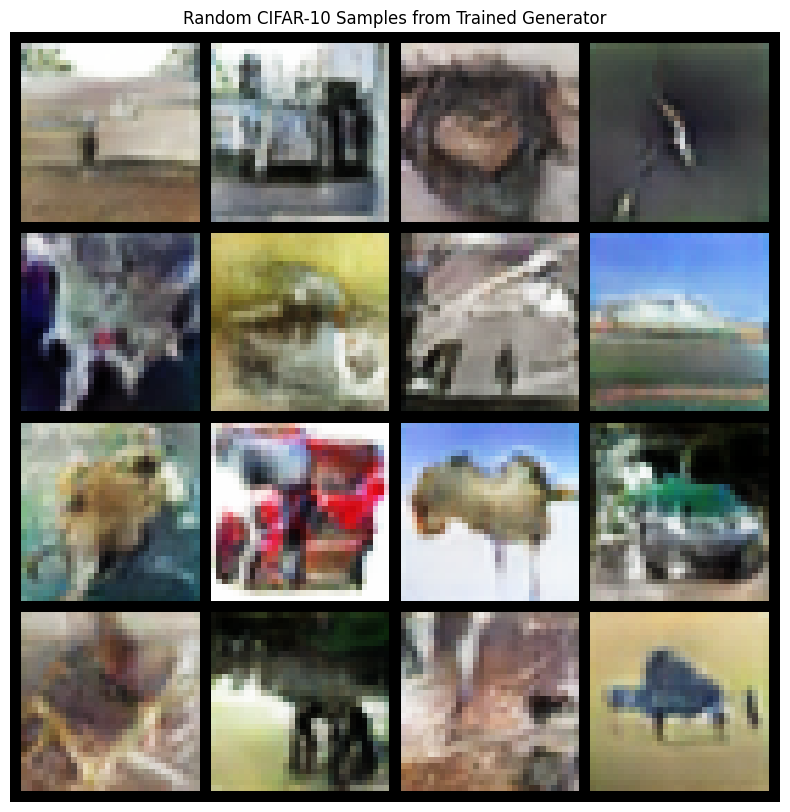

In [13]:
set_random_seed(seed)
# Run the training for a specific subset percentage
subset_percentage = 90  # Change this to test different subset sizes

# Train the GAN
g_losses, d_losses = train_gan(subset_percentage)

# Generate and display samples from the trained generator
generate_samples()